## Notebook elaborado para el curso de Mercado Capitales 2020-1

### Optimización de Markowitz

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

#Config
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.style.use('fivethirtyeight')
#np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [177]:
sp_500 = pd.read_excel('S&P_500_5_years.xlsx')
df_sp = sp_500[['Date','Adj Close']]

In [234]:
data = pd.read_excel('data_mrcado.xlsx').set_index('Date')
#data.drop('AMZ',axis=1,inplace=True)
#data.drop(['ADBE'],axis=1,inplace=True)
fecha_inicio = data.index.min()
fecha_final = data.index.max()
#Filtro SP
df_sp_period = df_sp[(df_sp['Date'] >= fecha_inicio)&(df_sp['Date'] <= fecha_final)].set_index('Date')
n_periodos = 252
print(df_sp_period.pct_change().std())
num_columns = len(data.columns)
#Estos weights deben estar en porcentajes
initial_weights = np.full(shape=num_columns, fill_value = (1/num_columns))

weights = np.array([0.0 , 13.22  ,32.94  ,39.08 , 0.82 , 6.51 , 7.42])

data_portfolio = data.copy()
data_portfolio['Portfolio'] = np.dot(data_portfolio, weights)
data_pct_change = data_portfolio.pct_change().dropna()
#Creo arrays de Rendimiento diario, anual, dsv_diaria, dsv_anual y sharpe. 
amount = 1000000
risk_free_rate = 0.0068

In [235]:
data

,AMZN,MSFT,NVDA,NFLX,V,AAPL,GOOGL
Date,,,,,,,
2019-06-11,1863.699951,130.494232,150.331329,351.269989,169.251297,192.512451,1081.040039
2019-06-12,1855.319946,129.891647,145.793976,345.559998,170.523346,191.899780,1079.099976
2019-06-13,1870.300049,130.711548,147.848221,343.429993,168.297272,191.860229,1091.010010
2019-06-14,1869.670044,130.839981,144.238297,339.730011,168.605347,190.466873,1086.300049
2019-06-17,1886.030029,131.235123,144.627197,350.619995,168.505966,191.603317,1093.890015
...,...,...,...,...,...,...,...
2020-06-04,2460.600098,182.919998,350.660004,414.329987,193.639999,322.320007,1414.300049
2020-06-05,2483.000000,187.199997,356.799988,419.600006,199.610001,331.500000,1440.020020
2020-06-08,2524.060059,188.360001,352.200012,419.489990,199.600006,333.459991,1448.040039


In [220]:
matrix_info = pd.DataFrame({'Rend_diario': data_pct_change.agg('mean'),
             'Rend_anual': (1 + data_pct_change.agg('mean'))**n_periodos - 1,
             'desv_diaria': data_pct_change.agg('std'),
             'desv_anual': data_pct_change.agg('std')*np.sqrt(n_periodos)})

matrix_info['sharpe_ratio'] = (matrix_info['Rend_anual'] - risk_free_rate)/matrix_info['desv_anual']

In [221]:
matrix_info.T

,AMZN,MSFT,NVDA,NFLX,V,AAPL,GOOGL,Portfolio
Rend_diario,0.001581,0.001945,0.004240,0.001184,0.001000,0.002724,0.001459,0.001930
Rend_anual,0.489169,0.631907,1.904114,0.347577,0.286464,0.984727,0.443853,0.625455
desv_diaria,0.019414,0.025033,0.034905,0.026048,0.025680,0.025182,0.022523,0.023265
desv_anual,0.308189,0.397386,0.554107,0.413506,0.407658,0.399754,0.357538,0.369314
sharpe_ratio,1.565175,1.573048,3.424097,0.824116,0.686027,2.446320,1.222395,1.675145


**Optimización del Portafolio**

In [222]:
#retornos
returns = data_pct_change.drop('Portfolio',axis=1) #porcentaje
cov_matrix = returns.cov() 
media_retornos = returns.mean() #tambien en porcentaje

In [223]:
def performance_anualizado_portafolio(weights, media_retornos, cov_matrix):
    """
    Me dará los retornos totales de mi portafolio, junto a la desv_standar del mismo
    """
    retornos_totales = np.sum(media_retornos*weights) * 252 #La media de retornos al día, por 252 días.
    desv_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) #Tengo la dsv stand del portafolio
    return desv_std, retornos_totales

In [224]:
def neg_sharpe_ratio(weights,media_retornos, cov_matrix, risk_free_rate):
    desv_standar_portafolio, retornos_portafolio = performance_anualizado_portafolio(weights, media_retornos, cov_matrix) #Obtengo la desv y retornos totales
    return -(retornos_portafolio - risk_free_rate)/desv_standar_portafolio

In [225]:
def max_sharpe(media_retornos, cov_matrix, risk_free_rate):
    """
    Función de maximización para el ratio de Sharpe
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix, risk_free_rate)
    restricciones = ({'type':'eq','fun':lambda x: np.sum(x)-1}) #Esta es la restricción para que los pesos sumen 1
    limite = (0.0,1.0) #Los limites de los valores de los pesos.
    limites = tuple(limite for accion in range(num_acciones)) #creo N limites
    result = sco.minimize(neg_sharpe_ratio, initial_weights, args=args,
                         method='SLSQP',bounds=limites, constraints=restricciones)
    return result

def volatilidad_portafolio(weights, media_retornos, cov_matrix):
    return performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[0]

def retorno_portafolio(weights, media_retornos, cov_matrix):
    return performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[1]

def neg_retorno_portafolio(weights, media_retornos, cov_matrix):
    return -performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[1]

def varianza_minima(media_retornos, cov_matrix):
    """
    Función de minimización de varianza del portafolio.
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    restricciones = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    limite = (0.0, 1.0)
    limites = tuple(limite for asset in range(num_acciones))
    
    result_min_varianza = sco.minimize(volatilidad_portafolio, num_acciones*[1./num_acciones,], args=args,
                                     method='SLSQP',bounds=limites,constraints = restricciones)
    return result_min_varianza

def max_rentabilidad(media_retornos, cov_matrix):
    """
    Función de maximización del retorno
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    restricciones = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    limite = (0.0, 1.0)
    limites = tuple(limite for asset in range(num_acciones))
    
    result_max_retorno = sco.minimize(neg_retorno_portafolio, num_acciones*[1./num_acciones,], args=args,
                                     method='SLSQP',bounds = limites,constraints=restricciones)
    return result_max_retorno

In [226]:
max_rentabilidad(media_retornos, cov_matrix)

     fun: -1.0683868161970678
     jac: array([-0.399, -0.490, -1.068, -0.298, -0.252, -0.686, -0.368])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.000])

In [227]:
#Hallando el portafolio con mínima varianza:
resultados_pesos_min_var = varianza_minima(media_retornos, cov_matrix)
resultados_pesos_min_var.x

array([0.658, 0.000, 0.000, 0.077, 0.155, 0.000, 0.109])

In [228]:
#Hallando el ratio de Sharpe
resultados_pesos_max_sharpe = max_sharpe(media_retornos, cov_matrix, risk_free_rate).x
resultados_pesos_max_sharpe

array([0.000, 0.000, 0.686, 0.000, 0.000, 0.314, 0.000])

##### Ahora intentemos graficar el portafolio con máximo ratio de sharpe

In [229]:
#Haremos primero las funciones para ubicar la frontera eficiente.

def retornos_eficientes(media_retornos, cov_matrix, target):
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    
    #Acá la restricción es el retorno del portafolio, pero con 
    restricciones = ({'type':'eq','fun': lambda x: retorno_portafolio(x, media_retornos, cov_matrix) - target},
                    {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    
    limites = tuple((0,1) for accion in range(num_acciones))
    
    retornos_eficientes = sco.minimize(volatilidad_portafolio, num_acciones*[1./num_acciones,], args = args, method='SLSQP', bounds = limites, constraints=restricciones)
    
    return retornos_eficientes

def frontera_eficiente(media_retornos, cov_matrix, rango_retornos):
    """
    Esta función me va a calcular varios portafolios eficientes en un dentro de un rango retornos requerido.
    Recuerda que el rango de retornos máximo, será el portafolio que me de más rentabilidad. Por lo tanto, tendré también que optimizar c/r a la rentabilidad.
    """
    eficientes = []
    for retorno in rango_retornos:
        eficientes.append(retornos_eficientes(media_retornos, cov_matrix, retorno))
    return eficientes

In [230]:
def frontera_eficiente_sharpe_var(media_retornos, cov_matrix, risk_free_rate,data, df_sp):
    
    #----------------------------Optimizaciones-------------------------
    sharpe_maximo = max_sharpe(media_retornos, cov_matrix, risk_free_rate)
    sharpe_dsv, sharpe_retornos = performance_anualizado_portafolio(weights=sharpe_maximo['x'], #Los weights serán los valores que me botan la maximización
                                                                    media_retornos = media_retornos, cov_matrix = cov_matrix)
    sharpe_max_posicion = pd.DataFrame(sharpe_maximo['x'], index = data.columns, columns=['Posicion'])
    sharpe_max_posicion['Posicion'] = [round(i*100,2) for i in sharpe_max_posicion['Posicion']]
    sharpe_max_posicion = sharpe_max_posicion.T
    print('Optimizando Ratio de Sharpe:')
    print(sharpe_max_posicion)
    
    volat_min = varianza_minima(media_retornos, cov_matrix)
    dsv_min_var, dsv_min_retornos = performance_anualizado_portafolio(weights=volat_min['x'], media_retornos=media_retornos, cov_matrix=cov_matrix)
    volat_min_posicion = pd.DataFrame(volat_min['x'], index=data.columns, columns=['Posicion'])
    volat_min_posicion['Posicion'] = [round(i*100,2) for i in volat_min_posicion['Posicion']]
    volat_min_posicion = volat_min_posicion.T
    print('-------------------------------------------------------------------------------------')
    print('Minimizando Varianza, según nuestro portafolio')
    print(volat_min_posicion)
    max_retorno = max_rentabilidad(media_retornos, cov_matrix)
    dsv_max_retorno, total_retorno_max = performance_anualizado_portafolio(weights=max_retorno['x'], media_retornos = media_retornos, cov_matrix=cov_matrix)
    max_retorno_posicion = pd.DataFrame(max_retorno['x'], index=data.columns, columns=['Posicion'])
    max_retorno_posicion['Posicion'] = [round(i*100,2) for i in max_retorno_posicion['Posicion']]
    max_retorno_posicion = max_retorno_posicion.T
    print('------------------------------------------------------------------------------------')
    print('MAx rentabilidad')
    print(max_retorno_posicion)
    cambio_pct_stocks = data.pct_change()
    retornos_medios_stocks = cambio_pct_stocks.mean()
    volatilidad_anual_stocks = np.std(cambio_pct_stocks) * np.sqrt(252)
    retornos_anual = media_retornos * 252
    
    #Ahora hacemos la figura
    fig, ax = plt.subplots(figsize=(10,7))
    ax.scatter(volatilidad_anual_stocks, retornos_anual, marker='o',s=200)
    
    #Pongo los nombres a cada uno de los puntos.
    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (volatilidad_anual_stocks[i], retornos_anual[i]), xytext=(10,0), textcoords='offset points')
    
    #Gráficos de max_sharpe y varianza minima
    ax.scatter(sharpe_dsv, sharpe_retornos, marker='*', color='r',s=500, label='Maximo Ratios de Sharpe')
    ax.scatter(dsv_min_var, dsv_min_retornos, marker='*', color='g',s=500, label='Minima Volatilidad')
    ax.scatter(df_sp.pct_change().std()*np.sqrt(252), df_sp.pct_change().mean()*252, marker ='*',color='c',s=500,label='S&P 500 index')
    print(total_retorno_max)
    #Ajustamos la máxima volatilidad de algún stock para el gráfico.
    target = np.linspace(dsv_min_retornos, total_retorno_max, 50) #Esta linea me va a generar un array de 50 muestras con límite de portafolio de máxima rentabilidad.
    
    portafolios_eficientes = frontera_eficiente(media_retornos, cov_matrix, target)
    
    #Grafico todos los portafolios eficientes.
    ax.plot([p['fun'] for p in portafolios_eficientes], target, linestyle='-.', color='black', label='frontera eficiente')
    
    ax.set_title('Optimización del segundo Portafolio')
    ax.set_xlabel('Volatilidad Anualizada')
    ax.set_ylabel('Retornos Anualizados')
    ax.legend(labelspacing=0.8)

Optimizando Ratio de Sharpe:
          AMZN  MSFT  NVDA  NFLX    V  AAPL  GOOGL
Posicion   0.0   0.0  68.6   0.0  0.0  31.4    0.0
-------------------------------------------------------------------------------------
Minimizando Varianza, según nuestro portafolio
           AMZN  MSFT  NVDA  NFLX      V  AAPL  GOOGL
Posicion  65.83   0.0   0.0  7.73  15.51   0.0  10.93
------------------------------------------------------------------------------------
MAx rentabilidad
          AMZN  MSFT   NVDA  NFLX    V  AAPL  GOOGL
Posicion   0.0   0.0  100.0   0.0  0.0   0.0    0.0
1.0683868161970678


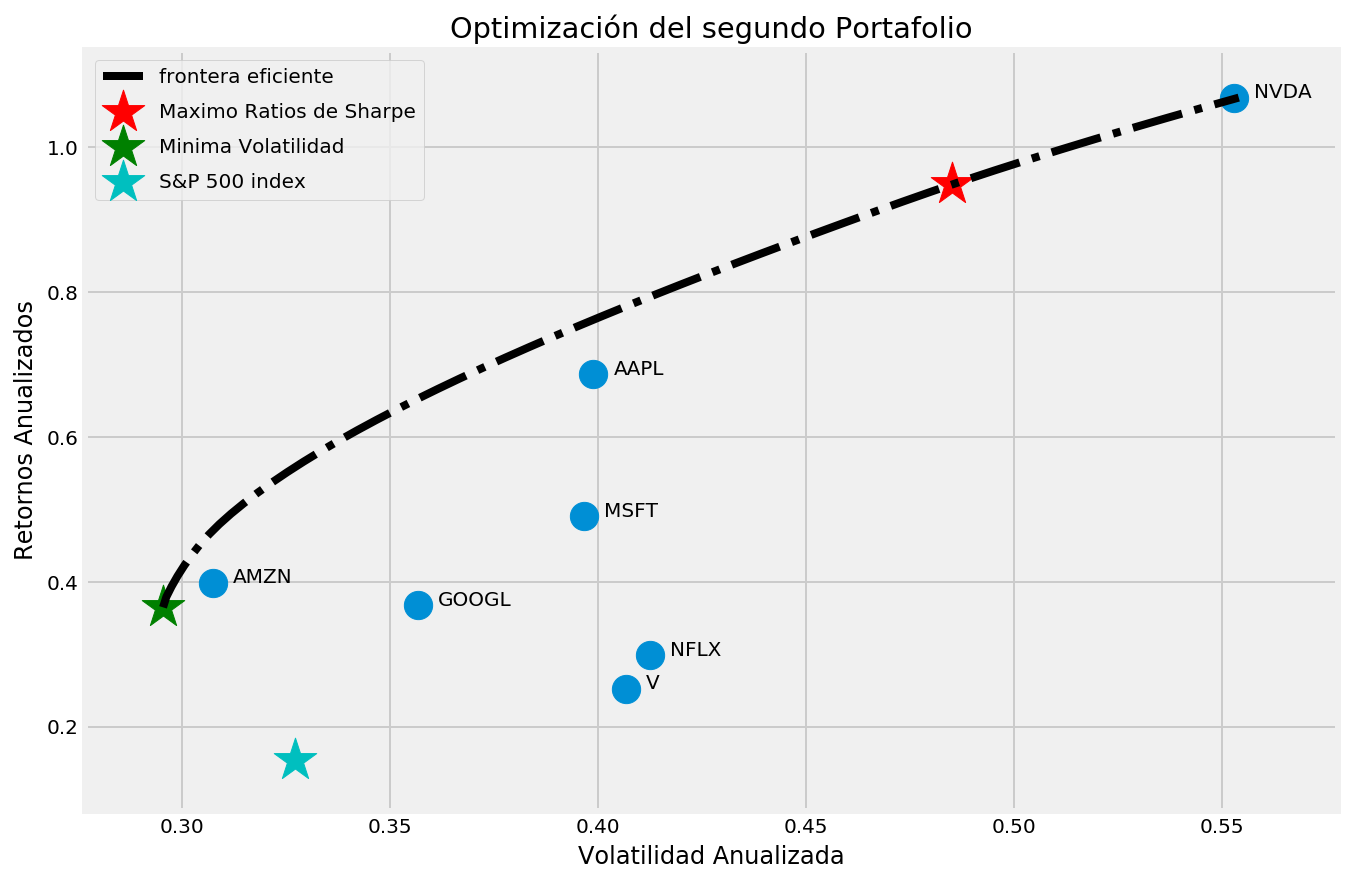

In [231]:
frontera_eficiente_sharpe_var(media_retornos, cov_matrix, risk_free_rate,data,df_sp_period)

In [203]:
weights = np.array([0.0 , 13.22 , 32.94 , 39.08 , 0.82 , 6.51 , 7.42])
portafolio_final = np.dot(data_portfolio.drop('Portfolio',axis=1), weights)

In [205]:
df_sp_period['Portafolio_final'] = portafolio_final[:-1]
df_sp_period=df_sp_period.rename(columns={'Adj Close':'S&P 500'})

Text(0, 0.5, 'Precio en $')

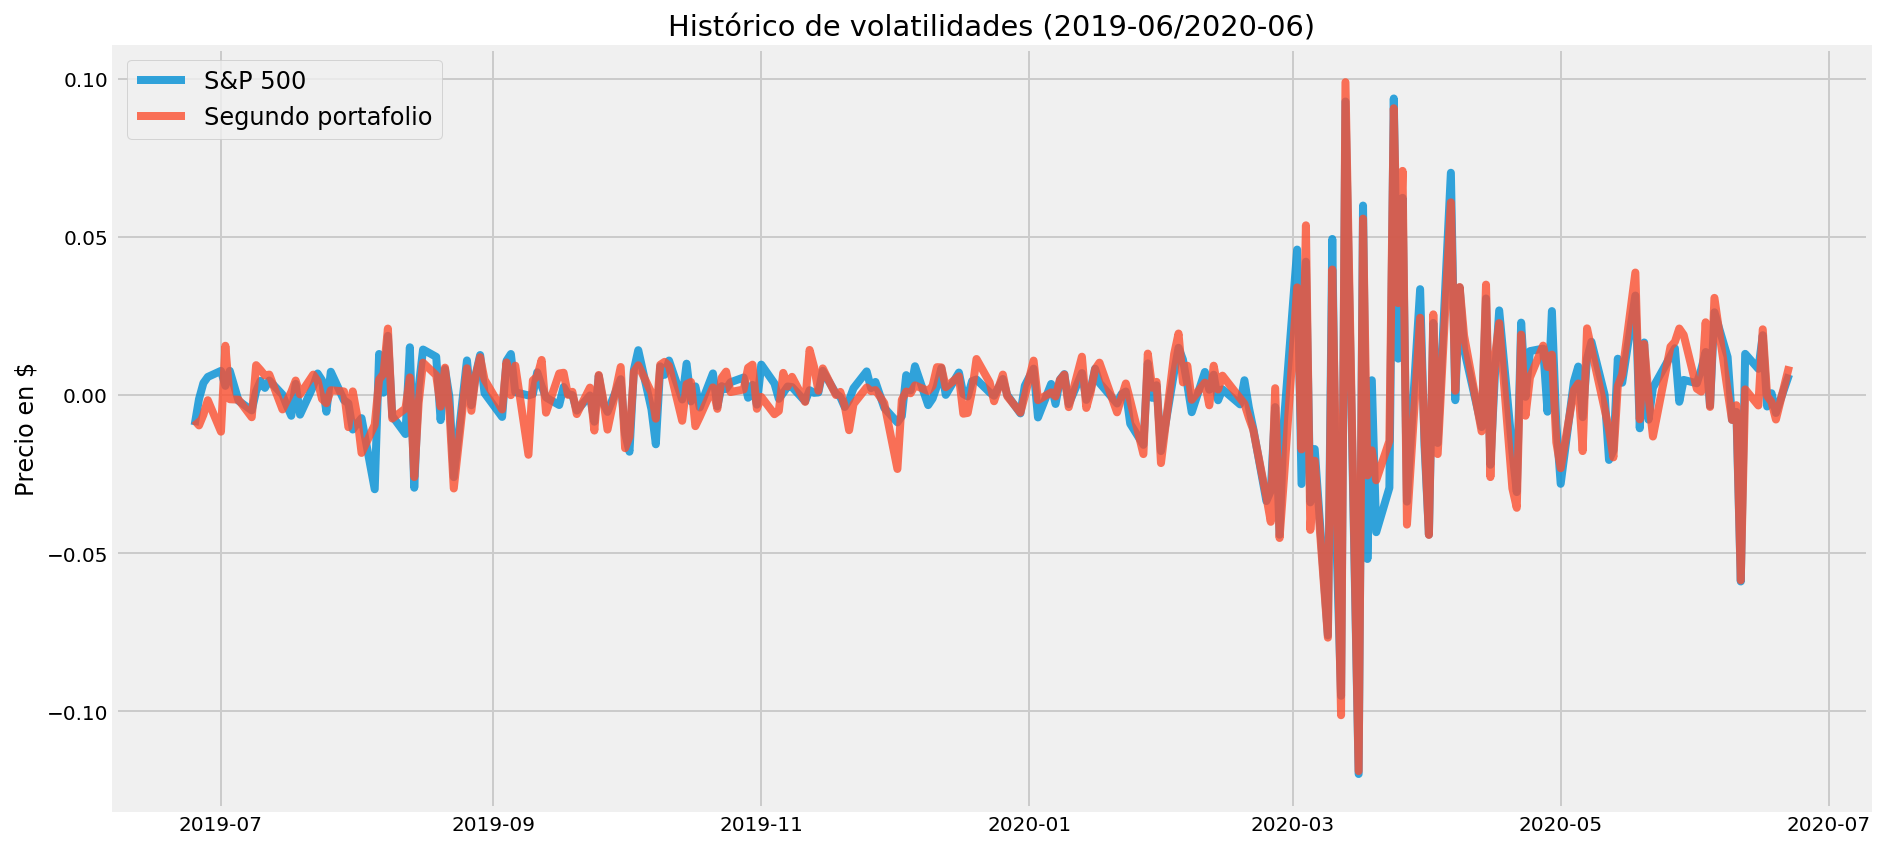

In [207]:
plt.figure(figsize=(14,7))
for c in df_sp_period.rename(columns={'Portafolio_final':'Segundo portafolio'}).columns.values:
    plt.plot(df_sp_period.index,df_sp_period.rename(columns={'Portafolio_final':'Segundo portafolio'}).pct_change()[c],alpha=0.8,label=c)

plt.title('Histórico de volatilidades (2019-06/2020-06)')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('Precio en $')

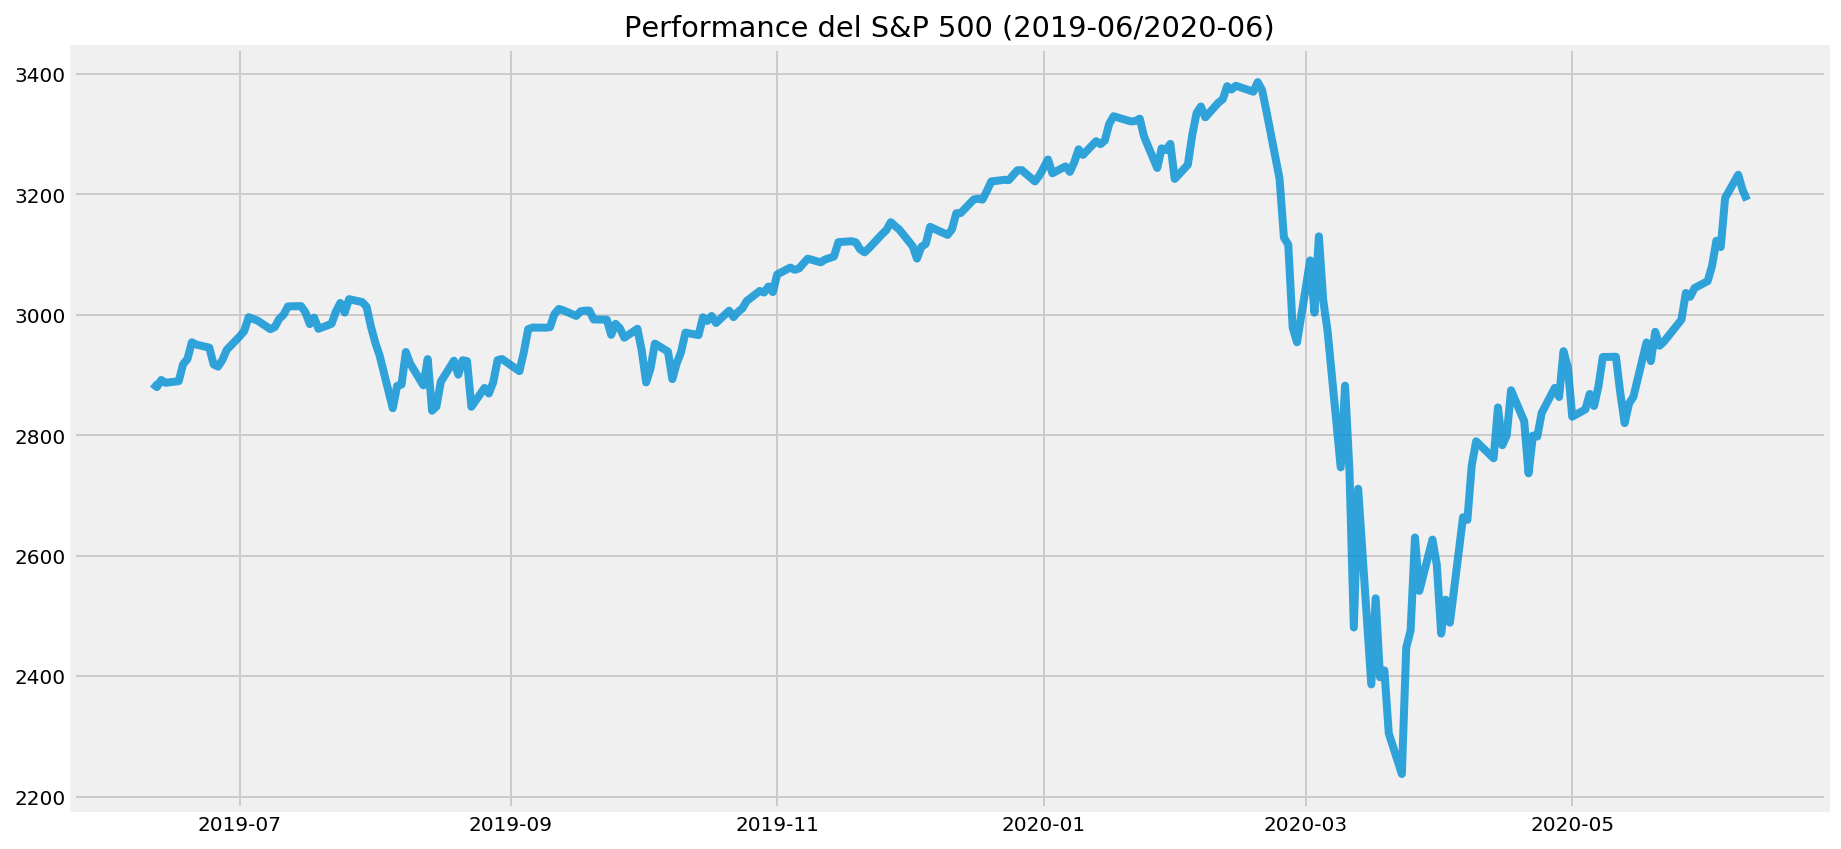

In [164]:
plt.figure(figsize=(14,7))
plt.title('Performance del S&P 500 (2019-06/2020-06)')
plt.plot(df_sp_period.index,df_sp_period['S&P 500'],alpha=0.8,label='S&P 500 (2019-06/2020-06)')

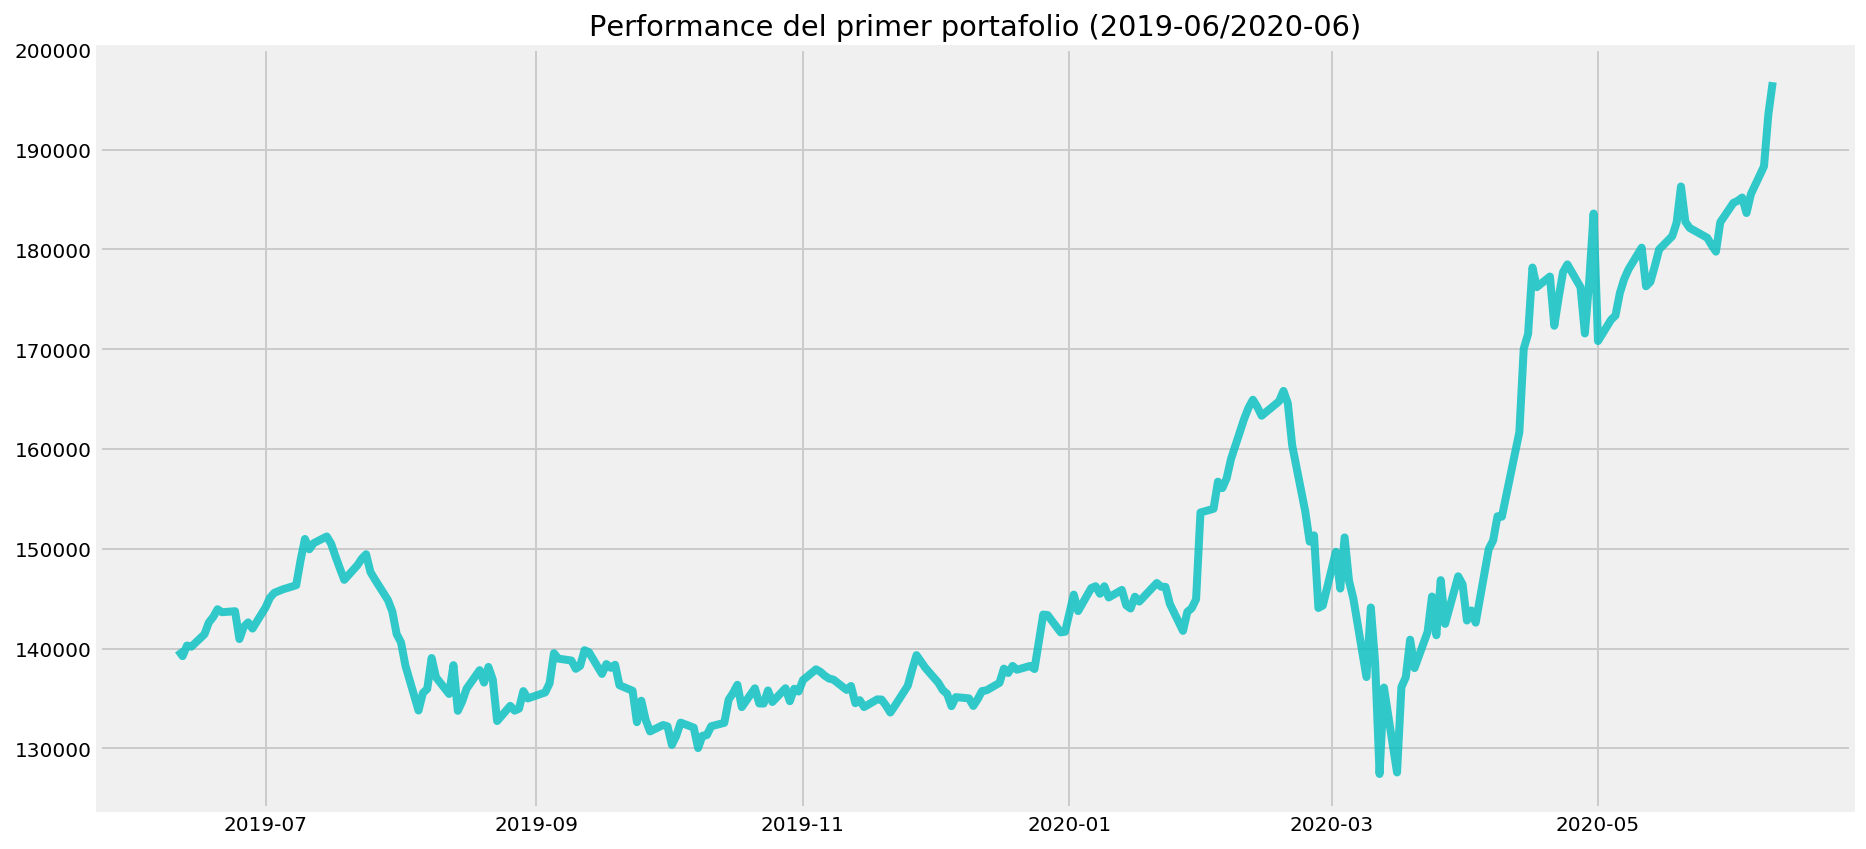

In [166]:
plt.figure(figsize=(14,7))
plt.title('Performance del primer portafolio (2019-06/2020-06)')
plt.plot(df_sp_period.index,df_sp_period['Portafolio_final'],alpha=0.8,label='Segundo portafolio (2019-06/2020-06)',color='c')

In [167]:
def get_beta_of_portfolio(portafolio, market):
    return np.cov(portafolio, market)[0,1]/np.var(market)

In [168]:
market = df_sp_period['S&P 500'].pct_change().dropna().values

In [169]:
portafolio = df_sp_period['Portafolio_final'].pct_change().dropna().values

In [170]:
get_beta_of_portfolio(portafolio,market)

0.6632915680950464